In [1]:
# Questi comandi permettono di usare in Jupyter le librerie di R presenti nel CRAN (Comprehensive R Archive Network)
country.code <- 'it'
url.pattern <- 'https://'  
repo.data.frame <- subset(getCRANmirrors(), CountryCode == country.code & grepl(url.pattern, URL))
options(repos = repo.data.frame$URL)

In [2]:
# Package utili: psych per le funzioni di stima dei parametri e readxl per poter leggere file excel
install.packages("psych")
install.packages("readxl")
install.packages("ltm")

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\RtmpaKjrDB\downloaded_packages
package 'readxl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\RtmpaKjrDB\downloaded_packages
package 'ltm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\RtmpaKjrDB\downloaded_packages


In [3]:
library(psych)
library("readxl")
library("ltm")

Loading required package: MASS
Loading required package: msm
Loading required package: polycor

Attaching package: 'polycor'

The following object is masked from 'package:psych':

    polyserial


Attaching package: 'ltm'

The following object is masked from 'package:psych':

    factor.scores



In [78]:
#' Legge un file csv e imposta la prima colonna con i nomi degli studenti come indici della tabella 
#'
#' @param path Percorso del file
#' @return La tabella corrispondente al file csv indicato
#' @examples
#' readCSV("file.csv")
#' readCSV("C:/Users/Marco/file.csv")
readCSV <- function(path) {
  read.csv(path, row.names = 1)
}

#' Legge un file excel e imposta la prima colonna con i nomi degli studenti come indici della tabella 
#'
#' @param path Percorso del file
#' @return La tabella corrispondente al file excel indicato
#' @examples
#' readEXCEl("file.xlsx")
#' readEXCEl("C:/Users/Marco/file.xlsx")
readEXCEl <- function(path) {
    items <- read_excel(path)
    items <- as.data.frame(items)
    rownames(items) <- items[,1]
    items <- items[,-1]
    items
}

In [79]:
datiDichot <- readEXCEl("EsameDic.xlsx")
datiDichot

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,1,1,1,1,0,1,1,0,0,1
S2,1,0,1,1,0,0,1,1,0,0
S3,1,1,1,1,0,1,1,1,1,0
S4,1,1,1,1,1,1,1,1,1,0
S5,1,0,1,1,1,1,1,0,0,1
S6,0,1,1,1,1,0,0,1,1,0
S7,1,1,0,0,1,1,1,0,0,0
S8,1,1,1,1,0,1,1,1,1,1
S9,1,1,1,1,1,0,1,1,1,0
S10,0,0,1,1,1,0,0,1,0,1


In [80]:
options(repr.plot.width=7, repr.plot.height=5) # Modifico dimensione dei plot

#' Stima le difficoltà degli esercizi
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @return Data frame di difficoltà stimate
#' @examples
#' estimateDifficultiesDichot(items)
estimateDifficultiesDichot <- function(items) {
    param <- rasch(items)
    tab <- coef(param)
    diff <- array(tab[,"Dffclt"])
    df <- data.frame(t(matrix(diff)))
    colnames(df) <- names(items)
    df
}

#' Genera un grafico per mostrare il livello di difficoltà di ciascun esercizio 
#'
#' @param diff Data frame di difficoltà
#' @examples
#' plotDifficulties(diff)
plotDifficulties <- function(diff) {
    nItems <- length(diff)
    diffLs <- unlist(diff, use.names=FALSE)
    plot(diffLs,xlim=c(1,nItems),ylim=c(-5,5),type="b",main="Difficulties plot",xlab="Items",ylab="Difficulty",xaxt="n",col="red",pch=16,lwd=2)
    axis(1, at=1:nItems, labels=names(diff))
    par(new = TRUE)
    plot(diffLs + 4.7, type = "h", xlim = c(1,nItems),ylim = c(0,10), xaxt='n', yaxt = "n", xlab = "", ylab = "", lty = 2)
}

#' Stima le abilità degli studenti
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @return Vettore di abilità stimate
#' @examples
#' estimateAbilities(items)
estimateAbilities <- function(items) {
    info <- irt.0p(items)
    info <- data.frame(info)
    theta <- info$theta0
    df <- data.frame(theta, row.names = rownames(items))
    df
}

#' Genera un istogramma per mostrare il livello di abilità degli studenti e la relativa quantità
#'
#' @param theta Vettore di abilità
#' @examples
#' plotAbilities(theta)
plotAbilities <- function(theta) {
    thetaLs <- unlist(theta, use.names=FALSE)
    hist(thetaLs,main="Ability histogram",xlab="Ability",ylab="Students",breaks=seq(-3,3,by=0.5),xlim=c(-3,3),col="royalblue3")
    axis(1, at=seq(-3, 3, by=0.5), labels=seq(-3, 3, by=0.5))        
}

In [81]:
#' Attraverso la tecnica di bootstrapping seleziona randomicamente 1000 righe dalla matrice dicotomica ed effettua su di esse la stima delle difficoltà
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @return Data frame di difficoltà stimate dalla tabella generata dalle estrazioni casuali
#' @examples
#' bootstrapping(items)
bootstrappingDichot <- function(items) {
    numberRows <- nrow(items)
    numberCols <- ncol(items)
    aux <- data.frame(matrix(0, ncol = numberCols, nrow = 0))   
    
    for (n in 0:1000){
        rowNum <- sample(1:numberRows, 1)
        row <- items[rowNum,]
        aux <- rbind(aux,row)
    }
    
    estimateDifficultiesDichot(aux)    
}

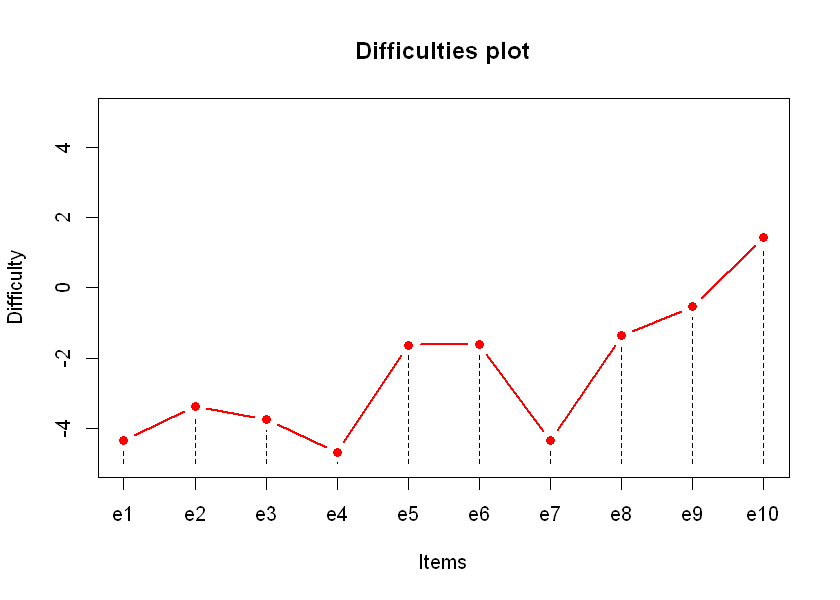

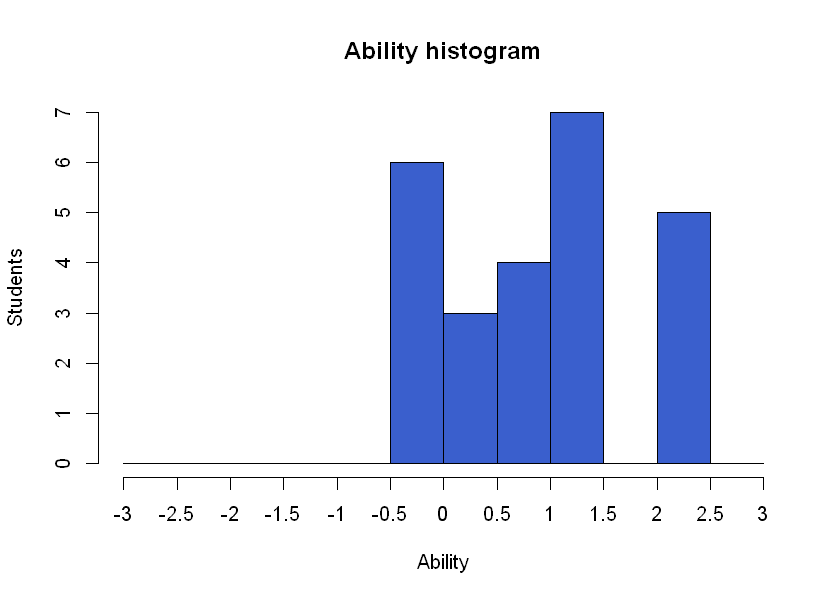

In [82]:
difficDichot <- bootstrappingDichot(datiDichot)
abil   <- estimateAbilities(datiDichot)
plotDifficulties(difficDichot)
plotAbilities(abil)

In [83]:
#' Calcola la probabilità che uno studente risolva correttamente un esercizio
#'
#' @param ability Abilità dello studente
#' @param difficulty Difficoltà dell'esercizio
#' @return Probabilità di rispondere correttamente, compresa tra 0 e 1
#' @examples
#' pl1(ability, difficulty)
pl1 <- function(ability, difficulty) {
    exp(ability - difficulty) / (1 + exp(ability - difficulty))
}

#' Determina la probabilità per ogni studente di risolvere correttamente ogni esercizio
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param diff Vettore di difficoltà
#' @param abil Vettore di abilità
#' @return Data frame di probabilità
#' @examples
#' calcProbabilites(items, diff, abil)
calcProbabilites <- function(items, diff, abil) {
    diff <- unlist(diff, use.names=FALSE)
    abil <- unlist(abil, use.names=FALSE)      
    probDf <- items
    namesCol <- names(probDf)
    namesRow <- row.names(probDf)
    j <- 1
    for (row in namesRow) {
        i <- 1
        for (col in namesCol) {
            prob <- pl1(abil[j],diff[i])
            probDf[row,col] <- round(prob, digits = 2)          
            i <- i + 1
        }
        j <- j + 1
    }
    probDf
}

In [84]:
calcProbabilites(datiDichot, difficDichot, abil)

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,0.99,0.99,0.99,1.00,0.92,0.92,0.99,0.90,0.80,0.36
S2,0.99,0.97,0.98,0.99,0.84,0.83,0.99,0.80,0.63,0.19
S3,1.00,0.99,0.99,1.00,0.95,0.95,1.00,0.94,0.87,0.49
S4,1.00,1.00,1.00,1.00,0.98,0.98,1.00,0.97,0.94,0.68
S5,0.99,0.99,0.99,1.00,0.92,0.92,0.99,0.90,0.80,0.36
S6,0.99,0.98,0.98,0.99,0.88,0.88,0.99,0.85,0.72,0.26
S7,0.99,0.97,0.98,0.99,0.84,0.83,0.99,0.80,0.63,0.19
S8,1.00,1.00,1.00,1.00,0.98,0.98,1.00,0.97,0.94,0.68
S9,1.00,0.99,0.99,1.00,0.95,0.95,1.00,0.94,0.87,0.49
S10,0.99,0.97,0.98,0.99,0.84,0.83,0.99,0.80,0.63,0.19


In [101]:
#' Valuta la bontà del mio stimatore scegliendo difficoltà e abilità, usa queste per generare una tabella dicotomica,
#' stima la difficoltà degli esercizi della tabella creata e confronta i valori iniziali da quelli stimati
#'
#' @return Data frame con le difficoltà scelte all'inizio, le difficoltà stimate e lo scostamento rilavato
#' @examples
#' simulation()
simulationDichot <- function() {
    diff  <- seq(-2, 2, 0.3)
    abil  <- seq(-1.5, 1.5, 0.015)
    items <- data.frame(matrix(0, ncol = length(diff), nrow = length(abil)))
    prob  <- calcProbabilites(items, diff, abil)

    namesCol  <- names(items)
    namesRow  <- row.names(items)
    for (row in namesRow) {
        for (col in namesCol) {
            items[row,col] <- rbinom(1, 1, prob[row,col])         
        }
    }
    
    diffEstim <- unlist(lapply(estimateDifficultiesDichot(items), round, 2))
    scost <- abs(unlist(lapply(diff - diffEstim , round, 2)))
    compare <- data.frame(diff, diffEstim, scost)   
    colnames(compare) <- c("Difficoltà iniziali","Difficoltà stimate", "Scostamento")
    compare
}

#' Confronta le difficoltà scelte con quelle stimate sovrapponendo i relativi grafici
#'
#' @param sim Tabella restituita dalla funzione simulation(), contenete le difficoltà iniziali, le difficoltà stimate ed il loro scostamento
#' @examples
#' compare(simulation())
compareSimul <- function(sim) {
    diff1 <- unlist(sim["Difficoltà iniziali"], use.names=FALSE)
    diff2 <- unlist(sim["Difficoltà stimate"], use.names=FALSE)
    plot(diff1,xlim=c(1,length(diff1)),ylim=c(-4,4),type="b",main="Comparison plot",xlab="Items",ylab="Difficulty",xaxt="n",col="red",pch=16,lwd=2)
    axis(1, at = 1:length(diff1), labels = 1:length(diff1))
    par(new = TRUE)
    plot(diff2, type = "b", xlim = c(1,length(diff2)),ylim = c(-4,4), xaxt='n', yaxt = "n", xlab = "", ylab = "", col = "blue", pch=16, lwd=2)
    legend(1, 3, legend=c("Difficoltà iniziali", "Difficoltà stimate"), col=c("red", "blue"), lty=1, cex=1, lwd=2, pch=16)
}

,Difficoltà iniziali,Difficoltà stimate,Scostamento
X1,-2.0,-2.48,0.48
X2,-1.7,-2.13,0.43
X3,-1.4,-1.56,0.16
X4,-1.1,-1.28,0.18
X5,-0.8,-0.87,0.07
X6,-0.5,-0.46,0.04
X7,-0.2,-0.26,0.06
X8,0.1,0.02,0.08
X9,0.4,0.38,0.02
X10,0.7,0.99,0.29


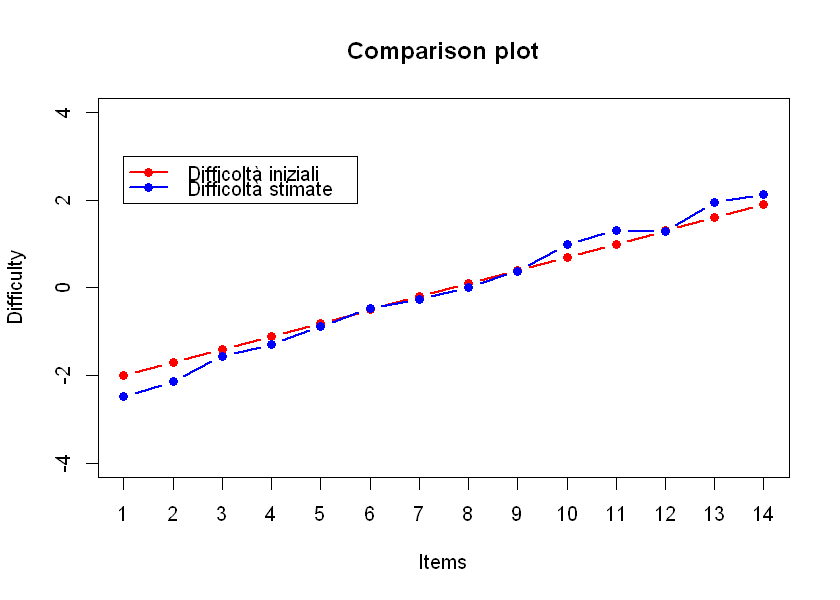

In [106]:
simul <- simulationDichot()
simul
compareSimul(simul)